In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

In [2]:
df=pd.read_csv("human_face_dataset.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.shape

(35887, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [5]:
df.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [6]:
df.columns

Index(['emotion', 'pixels', 'Usage'], dtype='object')

In [7]:
df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

#### Training and Testing data:

df_train,df_test = train_test_split(df,train_size=0.7,random_state=50)

y_train = df_train.pop('emotion')
X_train = df_train

y_test = df_test.pop('emotion')
X_test = df_test

print(X_train)
print(y_train)

                                                  pixels        Usage
27683  61 70 83 93 81 84 107 95 108 111 110 120 110 1...     Training
6731   87 85 95 107 97 106 86 90 111 102 61 44 39 42 ...     Training
24202  251 253 255 255 255 255 254 255 254 208 158 14...     Training
35482  221 218 217 215 212 206 188 195 197 173 161 16...  PrivateTest
25696  208 209 209 212 215 218 215 210 206 201 203 13...     Training
...                                                  ...          ...
8559   54 153 246 226 238 228 232 234 222 219 233 234...     Training
34887  180 190 189 196 197 197 197 196 196 194 174 15...  PrivateTest
32022  120 121 119 117 119 119 119 121 120 131 184 21...   PublicTest
22637  216 224 134 82 100 197 175 81 70 78 74 76 82 8...     Training
14000  254 254 253 253 250 255 222 102 77 69 61 64 61...     Training

[25120 rows x 2 columns]
27683    6
6731     0
24202    2
35482    2
25696    2
        ..
8559     3
34887    0
32022    3
22637    2
14000    6
Name: emotion

<AxesSubplot:>

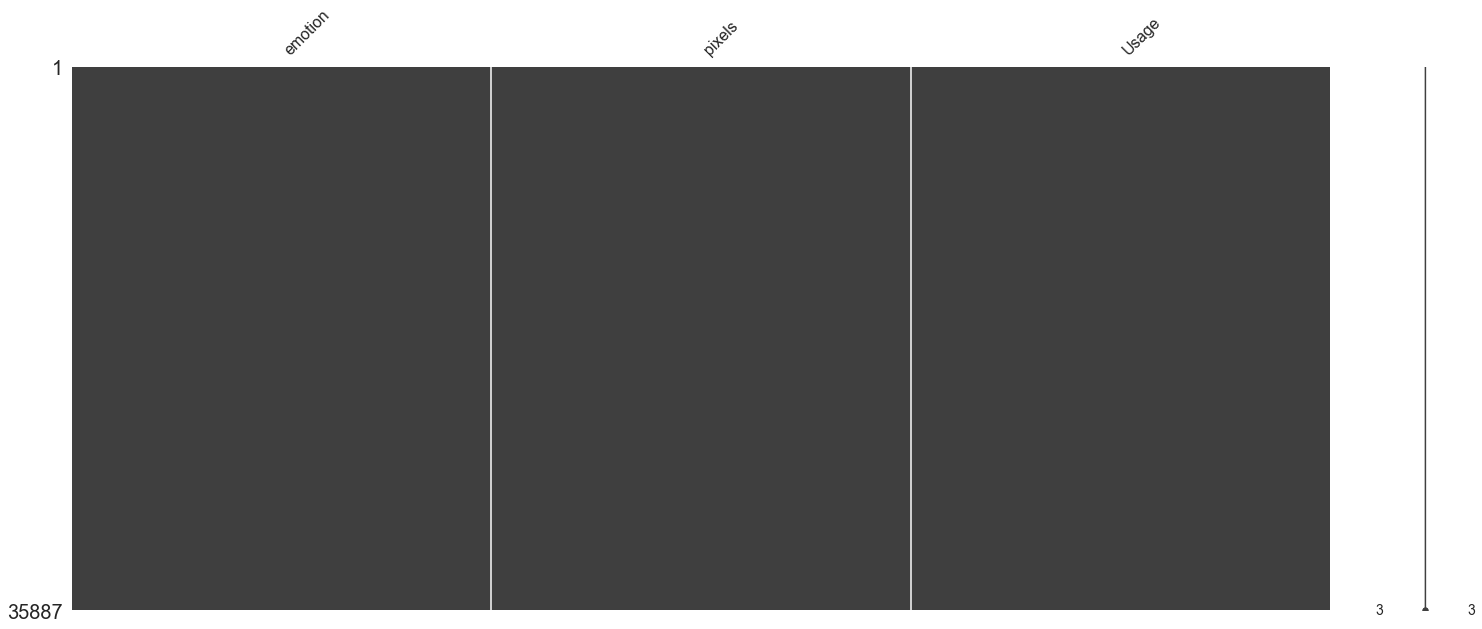

In [9]:
import missingno as msno
msno.matrix(df)

In [10]:
duplicated = df.duplicated().sum()
if duplicated:
    print("Duplicate rows in Dataset are {}".format(duplicated))
else:
    print("Dataset contains no duplicate values")
duplicated = df[df.duplicated(keep=False)]
duplicated.head()

Duplicate rows in Dataset are 1234


,emotion,pixels,Usage
30,3,234 233 228 231 234 233 236 230 236 196 112 85...,Training
38,0,255 82 0 3 0 0 0 0 0 0 3 0 16 17 3 60 29 0 1 2...,Training
50,2,99 95 101 114 124 129 128 127 128 124 123 125 ...,Training
62,3,210 161 140 166 159 98 96 141 157 137 110 107 ...,Training
69,5,43 43 43 40 45 63 93 140 144 153 159 167 168 1...,Training


In [11]:
df['emotion'].unique()
df.emotion.value_counts()
df[df['emotion'] == 4]

df.loc[df['emotion'] == 4, 'emotion'] = np.NaN
df['emotion'].unique()

df.pixels.value_counts()
df[df['pixels'] == 0]

df.loc[df['pixels'] == 0, 'pixels'] = np.NaN
df['pixels'].unique()

df = df.fillna(df.median()) # Replacing with Mean


<AxesSubplot:>

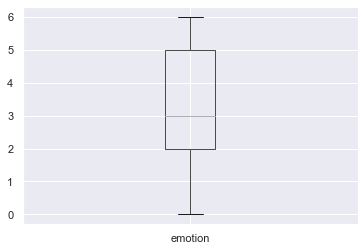

In [12]:
df.boxplot()

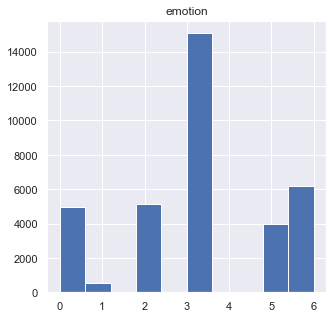

In [13]:
#bargrapgh_eda_dist
fig=plt.figure(figsize=(5,5))
ax=fig.gca()
df.hist(ax=ax)
plt.show()

<AxesSubplot:>

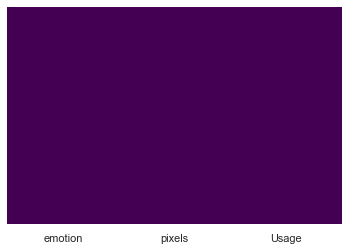

In [14]:
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

<AxesSubplot:>

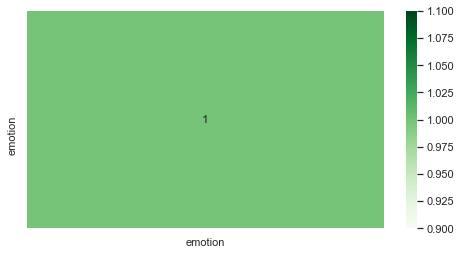

In [15]:
plt.figure(figsize=(8,4))
sns.heatmap(df.corr(),cmap='Greens',annot=True)

In [16]:
df["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

### Modelling ###

In [17]:
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import random
import sys
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import brewer2mpl

def emotion_count(y_train, classes):
    """
    The function re-classify picture with disgust label into angry label
    """
    emo_classcount = {}
    print ('Disgust classified as Angry')
    y_train.loc[y_train == 1] = 0
    classes.remove('Disgust')
    for new_num, _class in enumerate(classes):
        y_train.loc[(y_train == emotion[_class])] = new_num
        class_count = sum(y_train == (new_num))
        emo_classcount[_class] = (new_num, class_count)
    return y_train.values, emo_classcount



In [18]:
def load_data(sample_split=0.3, usage='Training',classes=['Angry','Happy'], filepath='human_face_dataset.csv'):
    """
    The function load provided CSV dataset and further reshape, rescale the data for feeding
    """
    df = pd.read_csv(filepath)
    df = df[df.Usage == usage]
    frames = []
    classes.append('Disgust')
    for _class in classes:
        class_df = df[df['emotion'] == emotion[_class]]
        frames.append(class_df)
    data = pd.concat(frames, axis=0)
    rows = random.sample(list(data.index), int(len(data)*sample_split))
    data = data.loc[rows]
    x = list(data["pixels"])
    X = []
    for i in range(len(x)):
        each_pixel = [int(num) for num in x[i].split()]
        X.append(each_pixel)
    ## reshape into 48*48*1 and rescale
    X = np.array(X)
    X = X.reshape(X.shape[0], 48, 48,1)
    X = X.astype("float32")
    X /= 255
    
    y_train, new_dict = emotion_count(data.emotion, classes)
    y_train = to_categorical(y_train)
    return X, y_train


In [19]:
## All three datasets are well loaded accordingly
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
emo     = ['Angry', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

X_test, y_test = load_data(sample_split=1.0,classes=emo,
usage='PrivateTest')

X_train, y_train = load_data(sample_split=1.0,classes=emo,
usage= 'Training')

X_val,y_val = load_data(sample_split=1.0,classes=emo,
usage= 'PublicTest')

Disgust classified as Angry
Disgust classified as Angry
Disgust classified as Angry


In [20]:
## The shape of loaded data is under examination
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(28709, 48, 48, 1)
(28709, 6)
(3589, 48, 48, 1)
(3589, 6)
(3589, 48, 48, 1)
(3589, 6)


In [21]:
def save_data(X_test, y_test, fname=''):
    """
    The function stores loaded data into numpy form for further processing
    """
    np.save( 'X_test' + fname, X_test)
    np.save( 'y_test' + fname, y_test)
save_data(X_test, y_test,"_privatetest6_100pct")
X_fname = 'X_test_privatetest6_100pct.npy'
y_fname = 'y_test_privatetest6_100pct.npy'
X = np.load(X_fname)
y = np.load(y_fname)
print ('Private test set')
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print (labels, counts)

Private test set
['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral'] [546 528 879 594 416 626]


In [22]:
# Final Model Architecture:
from keras import layers
from keras import models
from keras import optimizers

modelN = models.Sequential()
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                        input_shape=(48, 48, 1)))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(6, activation='softmax'))

# optimizer:
modelN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print ('Training....')

# nb_epoch = 32
# batch_size = 128

modelF = modelN.fit(X_train, y_train, batch_size=64, epochs=10,
          validation_data=(X_val, y_val), shuffle=True, verbose=1)

Training....
Epoch 1/10
449/449 [==============================] - 500s 1s/step - loss: 1.7626 - accuracy: 0.2501 - val_loss: 1.7628 - val_accuracy: 0.2494
Epoch 2/10
449/449 [==============================] - 462s 1s/step - loss: 1.7613 - accuracy: 0.2513 - val_loss: 1.7613 - val_accuracy: 0.2494
Epoch 3/10
449/449 [==============================] - 457s 1s/step - loss: 1.7611 - accuracy: 0.2513 - val_loss: 1.7619 - val_accuracy: 0.2494
Epoch 4/10
449/449 [==============================] - 493s 1s/step - loss: 1.7606 - accuracy: 0.2513 - val_loss: 1.7617 - val_accuracy: 0.2494
Epoch 5/10
449/449 [==============================] - 458s 1s/step - loss: 1.7606 - accuracy: 0.2513 - val_loss: 1.7614 - val_accuracy: 0.2494
Epoch 6/10
449/449 [==============================] - 456s 1s/step - loss: 1.7605 - accuracy: 0.2513 - val_loss: 1.7616 - val_accuracy: 0.2494
Epoch 7/10
449/449 [==============================] - 432s 962ms/step - loss: 1.7603 - accuracy: 0.2513 - val_loss: 1.7626 - val_

(1, 48, 48, 1)


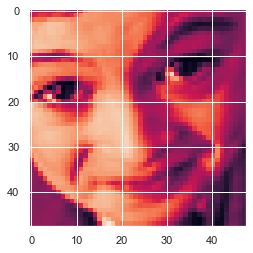

In [23]:
## Similarly we canvisualize any input with self-defined index with following code
input_img = X[6:7,:,:,:] 
print (input_img.shape)
plt.imshow(input_img[0,:,:,0])
plt.show()

In [24]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [25]:
score = modelN.evaluate(X, y, verbose=0)
print ("model %s: %.2f%%" % (modelN.metrics_names[1], score[1]*100))

model accuracy: 24.49%


In [26]:
# prediction and true labels
y_prob = modelN.predict(X, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y]

In [27]:
def plot_subjects(start, end, y_pred, y_true, title=False):
    """
    The function is used to plot the picture subjects
    """
    fig = plt.figure(figsize=(12,12))
    emotion = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad', 4:'Surprise', 5:'Neutral'}
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img[0,:,:,0], cmap="gray")
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel(emotion[y_true[i]],fontsize=12)
        else:
            plt.xlabel(emotion[y_true[i]], fontsize=12)
        if title:
            plt.title(emotion[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

In [28]:
def plot_probs(start,end, y_prob):
    """
    The function is used to plot the probability in histogram for six labels 
    """
    fig = plt.figure(figsize=(12,12))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        set3 = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
        ax.bar(np.arange(0,6), y_prob[i], color=set3,alpha=0.5)
        ax.set_xticks(np.arange(0.5,6.5,1))
        labels = ['angry', 'fear', 'happy', 'sad', 'surprise','neutral']
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [29]:
def plot_subjects_with_probs(start, end, y_prob):
    """
    This plotting function is used to plot the probability together with its picture
    """
    iter = int((end - start)/6)
    for i in np.arange(0,iter):
        plot_subjects(i*6,(i+1)*6-1, y_pred, y_true, title=False)
#         plot_probs(i*6,(i+1)*6-1, y_prob)

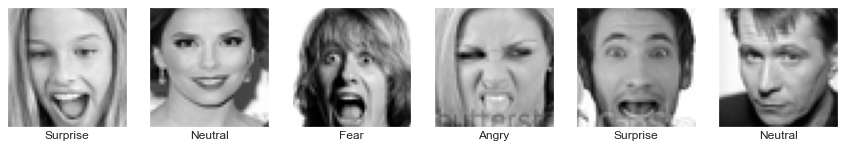

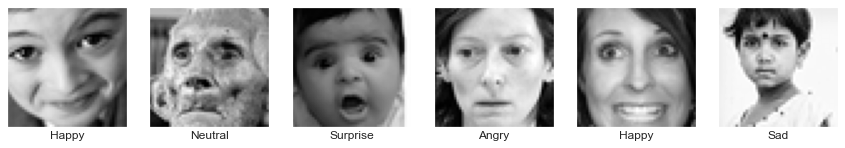

In [30]:
plot_subjects_with_probs(0, 12, y_prob)